In [1]:
import os
import json
from pprint import pprint
from copy import deepcopy
from tqdm.notebook import tqdm

from nltk.corpus import stopwords

import numpy as np
import random
import string
import re
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import collections
from nltk.util import ngrams
import nltk
import networkx as nx
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
nh = pd.read_csv('../../data/cases_nh.csv')

In [3]:
nh = nh[nh.type == 'criminal']
nh.head()

,file name,title,type,decision,text
6,kornb023.pdf,THE STATE OF NEW HAMPSHIRE v. KARL KORNBREKKE,criminal,not affirmed,"[""NOTICE: This opinion is subject to motions f..."
8,labra011.pdf,THE STATE OF NEW HAMPSHIRE v. MICHAEL J. LABRA...,criminal,affirmed,"[""NOTICE: This opinion is subject to motions f..."
10,jenot137.pdf,THE STATE OF NEW HAMPSHIRE v. DOUGLAS JENOT,criminal,affirmed,"[""NOTICE: This opinion is subject to motions f..."
17,munoz039.pdf,THE STATE OF NEW HAMPSHIRE v. PETER MUNOZ,criminal,affirmed,"[""NOTICE: This opinion is subject to motions f..."
19,duran133.pdf,THE STATE OF NEW HAMPSHIRE v. DIEGO DURAN,criminal,affirmed in part,"['', ""(Corrected Version) NOTICE: This opinion..."


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf(X, n):
    '''
        :param: X: text data
        :param: n: max_feature of TfidfVectorizer
    '''
    vectorizer = TfidfVectorizer(stop_words='english',max_features=n)
    tfidf = vectorizer.fit_transform(X)
    word = vectorizer.get_feature_names()
    return word

In [5]:
criminal_common_word = tfidf(nh['text'],20)
criminal_common_word +=['might','www','may','two','due','also','iii','even','though','whether', 'http', 'one']
criminal_common_word

['argues',
 'case',
 'counsel',
 'court',
 'defendant',
 'did',
 'evidence',
 'hampshire',
 'id',
 'jury',
 'new',
 'omitted',
 'police',
 'rsa',
 'rule',
 'state',
 'statute',
 'testimony',
 'trial',
 'victim',
 'might',
 'www',
 'may',
 'two',
 'due',
 'also',
 'iii',
 'even',
 'though',
 'whether',
 'http',
 'one']

In [6]:
import re
def clean_common_word(text):           # delect the number, punctuation and criminal_word
    #text = re.sub("[\s+\.\!\/_,$%^*()+\"\'\[\]]+|[+——！，。？、~@#￥%……&*（）:;]+", " ", text)  # remove punctuation
    text =  re.sub("[^a-zA-Z#]", " ", text) 
    words=text.lower().split()          # lower case
    words = [w for w in words if len(w)>=3]
    stoplist = stopwords.words('english')
    words = [word for word in words if word not in stoplist]
    words = [word for word in words if word not in criminal_common_word]
    return " ".join(words)

In [7]:
def handle_all_cases(df):
    for i in range(len(df)):
        df.text.iloc[i] = clean_common_word(df.text.iloc[i])
    return df

In [8]:
nh = handle_all_cases(nh)

In [9]:
reversed = nh[nh.decision == 'not affirmed']
affirmed = nh[nh.decision == 'affirmed']

In [10]:
# all criminal cases words

all_words = []
for i in range(len(nh)):
    tmp = nh.text.iloc[i].split(' ')
    for t in tmp:
        all_words.append(t)

In [11]:
# all reversed criminal cases words

r_all_words = []
for i in range(len(reversed)):
    tmp = reversed.text.iloc[i].split(' ')
    for t in tmp:
        r_all_words.append(t)

In [12]:
# all affirmed criminal cases words

a_all_words = []
for i in range(len(affirmed)):
    tmp = affirmed.text.iloc[i].split(' ')
    for t in tmp:
        a_all_words.append(t)

In [13]:
# Define ngram

def create_ngramlist(all_word, wordchain, most_common_num):
    '''
        :param: all_word: str list, contains all text words
    '''
    wordChain = wordchain
    ngramsList = ngrams(all_word, wordChain)
    result = collections.Counter(ngramsList)

    # Convert to dataframe
    ngramsList_df = pd.DataFrame(result.most_common(most_common_num),
                             columns=['n-gram', 'count'])

    return ngramsList_df

#ngram = ngramsList_df['n-gram']
#y_pos = np.arange(len(ngram))
# counts = ngramsList_df['count']


# plt.figure(figsize=(9,11))
# sns.barplot(x=counts,y=ngram)

In [37]:
def create_graph_conections(importantWord, data,filename, weight):
    # Create dictionary of bigrams and their counts
    d = data.set_index('n-gram').T.to_dict('records')
    # Create network plot 
    G = nx.Graph()
    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v*weight))
    

    #G.add_node(importantWord, weight=100)
    fig, ax = plt.subplots(figsize=(20, 15))
    pos = nx.spring_layout(G, k=1)
    
    edge_width = [0.0015*G[u][v]['weight'] for u,v in G.edges()]
    nodecolor = [G.degree(v) for v in G]

    
    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=14,
                     font_color = 'black',
                     node_shape='o',
                     node_size=300,
                     width=1,
                     cmap=plt.cm.Blues,
                     alpha=0.5,
                     edge_width=edge_width,
                     edge_color='grey',
                     node_color=nodecolor,
                     with_labels = True,
                     style = 'dashed',
                     ax=ax)
    
    # Create offset labels
#     for key, value in pos.items():
#         x, y = value[0], value[1]
#         ax.text(x, y,
#                 s=key,
#                 bbox=dict(facecolor='red', alpha=0.25),
#                 horizontalalignment='center', fontsize=11)
    plt.savefig(filename)
    plt.show()
    

Network graphic related to the word "sexual"


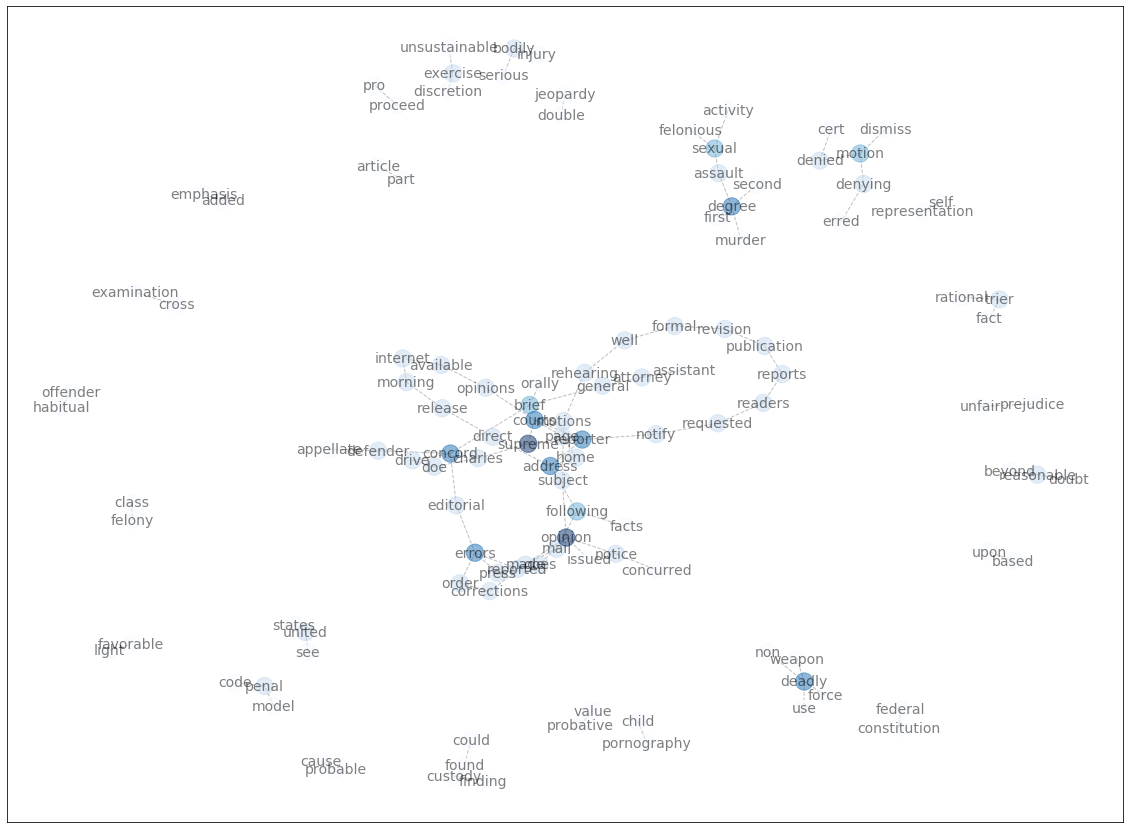

In [38]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['sexual']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(r_all_words,wordChain, 100)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/criminal_reverse.png", 10)    

possession cocaine，serious injury injury, 有 sexually violent, sex offender,affirmed 没有sexual,self defense,abuse child,nolo contendere(无罪申诉)，,abuse child

Network graphic related to the word "sexual"


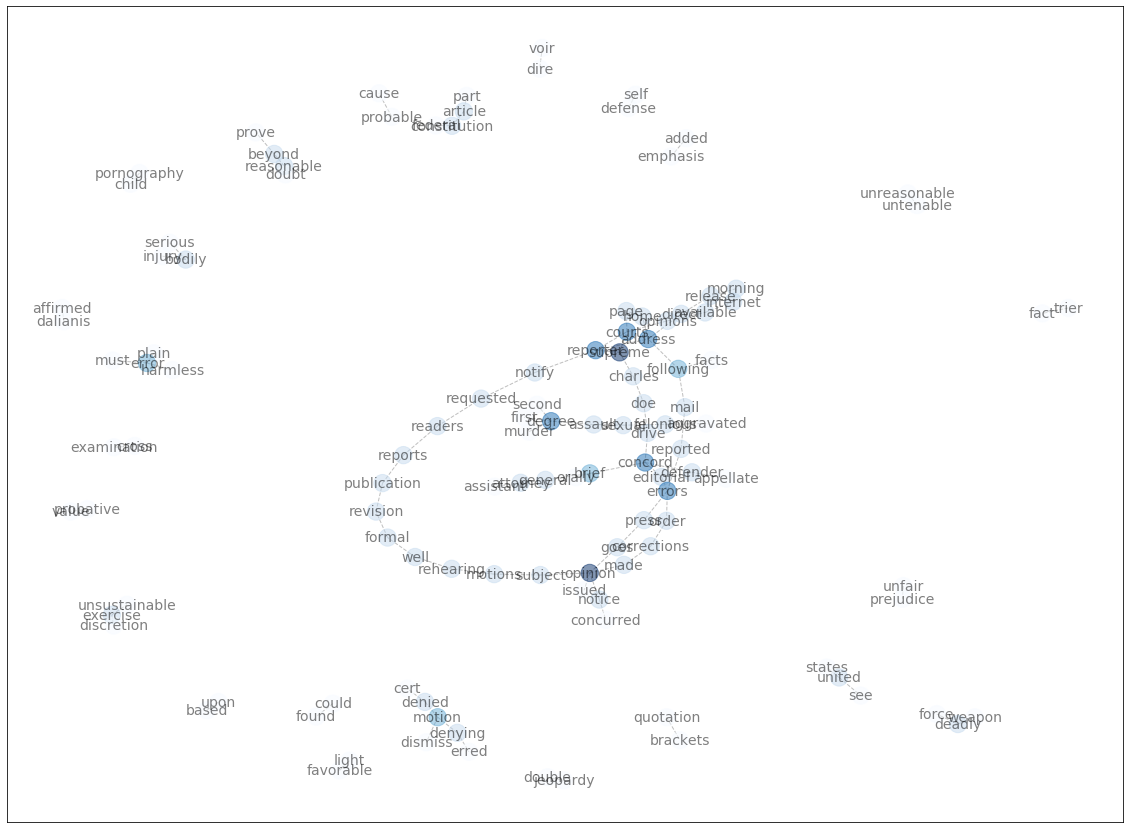

In [51]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['sexual'
                  ]

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(a_all_words,wordChain, 100)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/criminal_affirm.png", 10)    

100: firearm committing , without imprisonment

In [40]:
informant = nh[nh.text.str.contains('informant')]
non_informant =  nh[~nh.text.str.contains('informant')]
informant.shape

(15, 5)

In [41]:
info_all_words = []
for i in range(len(informant)):
    tmp = informant.text.iloc[i].split(' ')
    for t in tmp:
        info_all_words.append(t)

Network graphic related to the word "informant"


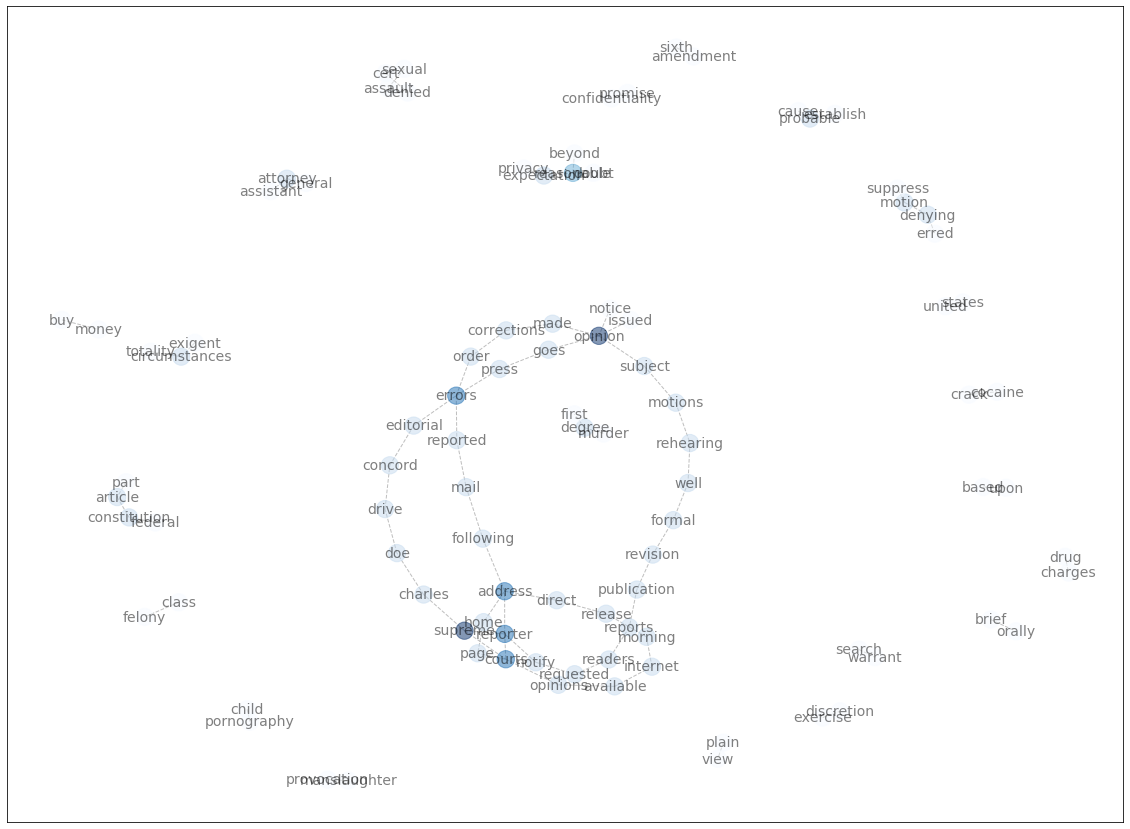

In [42]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['informant']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(info_all_words,wordChain, 80)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/informant.png", 40)    

100:involving torture,weapon discharging, firearm commiting,informant convict/cannot, 

In [43]:
non_info_all_words = []
for i in range(len(non_informant)):
    tmp = non_informant.text.iloc[i].split(' ')
    for t in tmp:
        non_info_all_words.append(t)

Network graphic related to the word "informant"


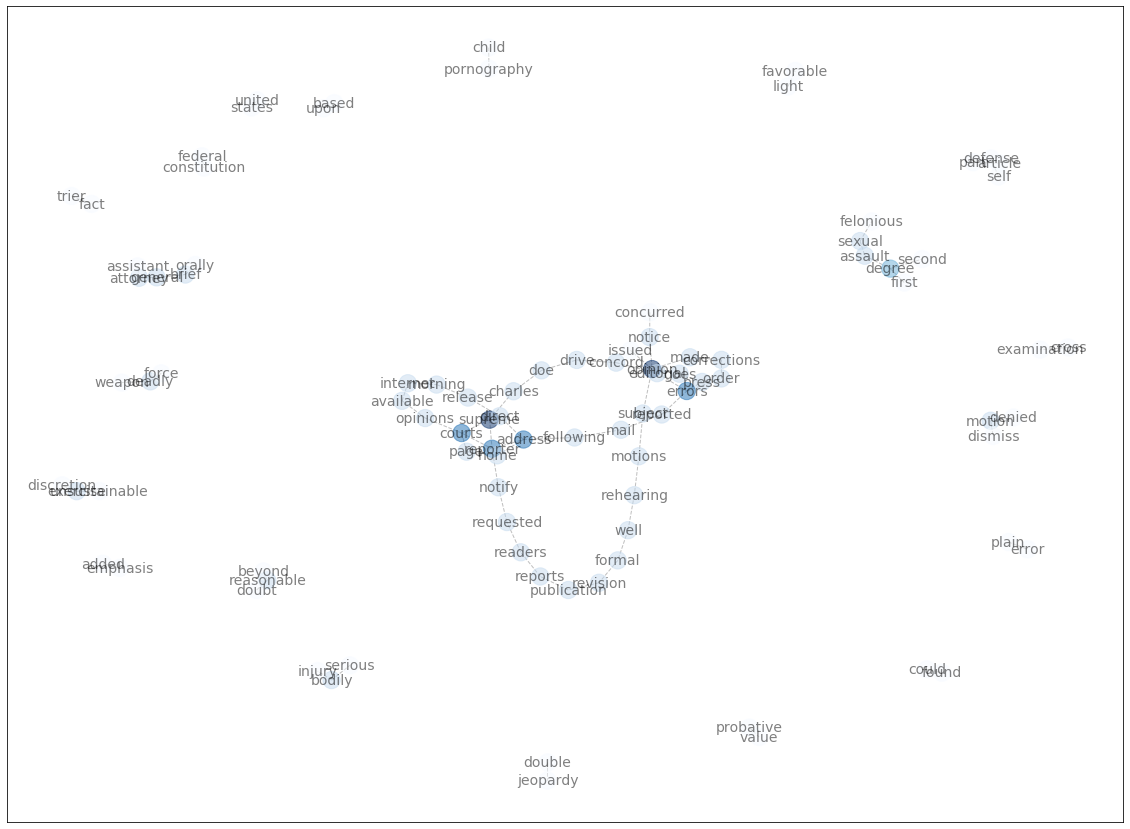

In [53]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['informant']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(non_info_all_words,wordChain, 80)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/informant.png", 5)    

In [45]:
re_informant = informant[informant.decision=='not affirmed']
aff_informant =  informant[informant.decision=='affirmed']

In [46]:
re_info_all_words = []
for i in range(len(re_informant)):
    tmp = re_informant.text.iloc[i].split(' ')
    for t in tmp:
        re_info_all_words.append(t)

Network graphic related to the word "informant"


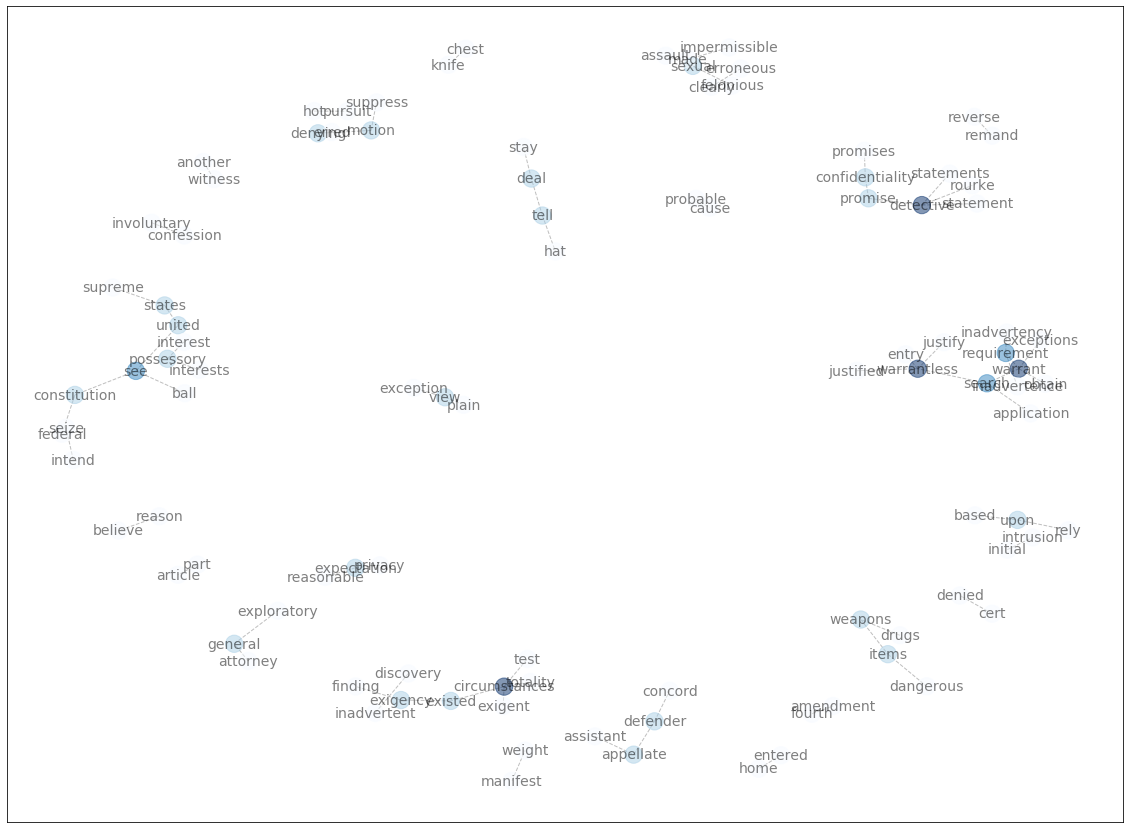

In [47]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['informant']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(re_info_all_words,wordChain, 70)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/informant_reversed.png", 50) 

startling event, child/sexual

In [48]:
aff_info_all_words = []
for i in range(len(aff_informant)):
    tmp = aff_informant.text.iloc[i].split(' ')
    for t in tmp:
        aff_info_all_words.append(t)

Network graphic related to the word "informant"


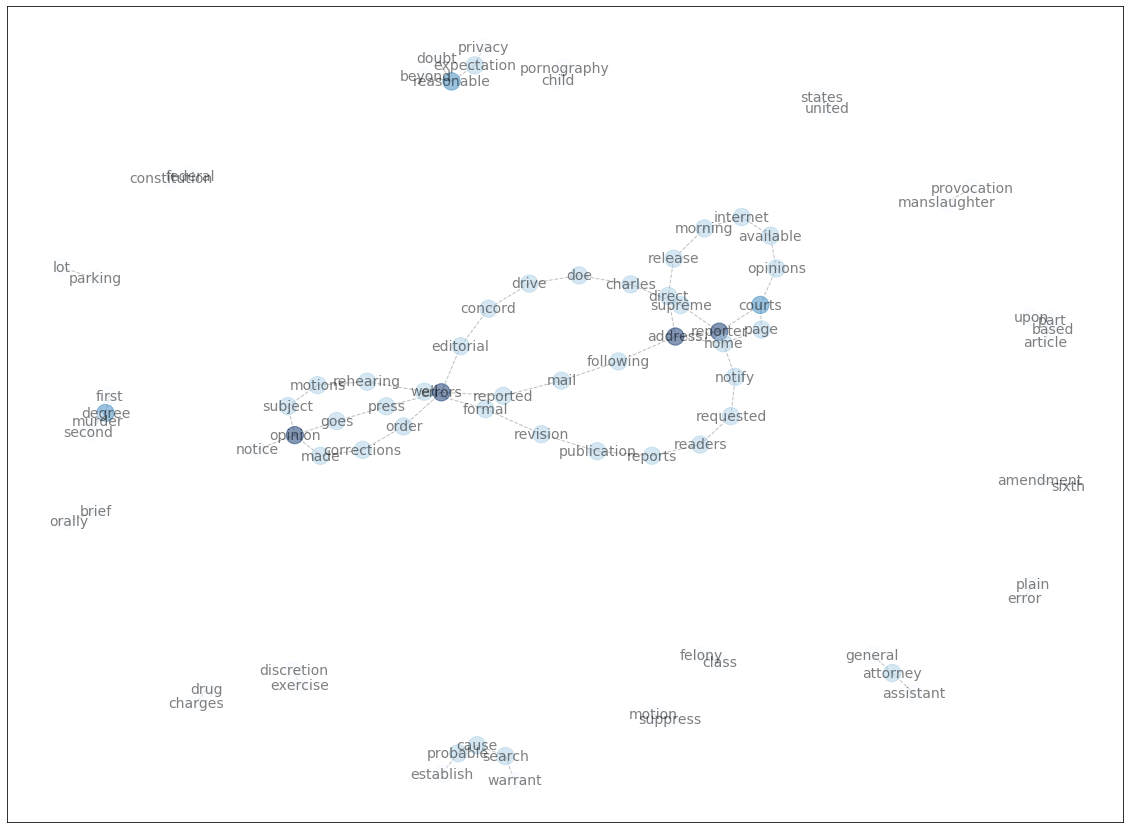

In [49]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['informant']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(aff_info_all_words,wordChain, 70)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/informant_affirm.png", 50 ) 

involving torture

In [54]:
re_non_informant = reversed[~reversed.text.str.contains('informant')]

In [55]:
re_non_info_all_words = []
for i in range(len(re_non_informant)):
    tmp = re_non_informant.text.iloc[i].split(' ')
    for t in tmp:
        re_non_info_all_words.append(t)

Network graphic related to the word "informant"


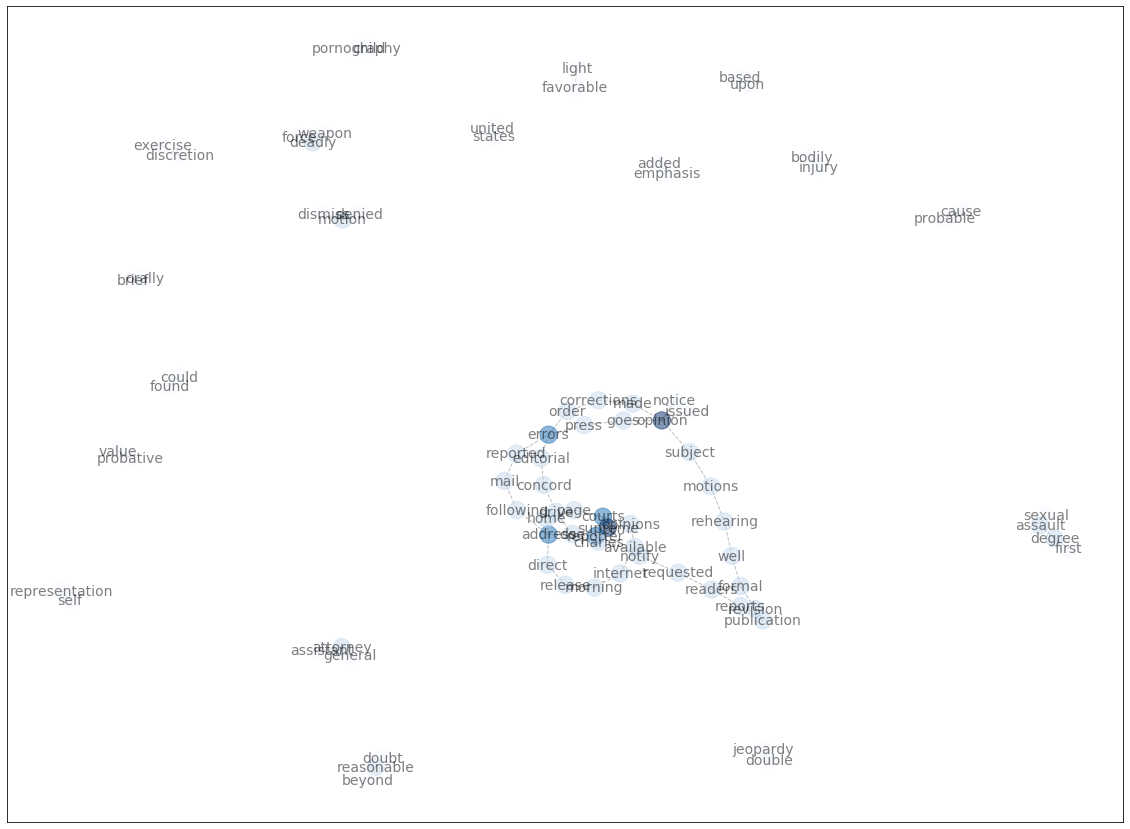

In [68]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['informant']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(re_non_info_all_words,wordChain, 70)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/informant_affirm.png", 30 ) 

In [59]:
aff_non_informant = affirmed[~affirmed.text.str.contains('informant')]

In [60]:
aff_non_info_all_words = []
for i in range(len(aff_non_informant)):
    tmp = aff_non_informant.text.iloc[i].split(' ')
    for t in tmp:
        aff_non_info_all_words.append(t)

Network graphic related to the word "informant"


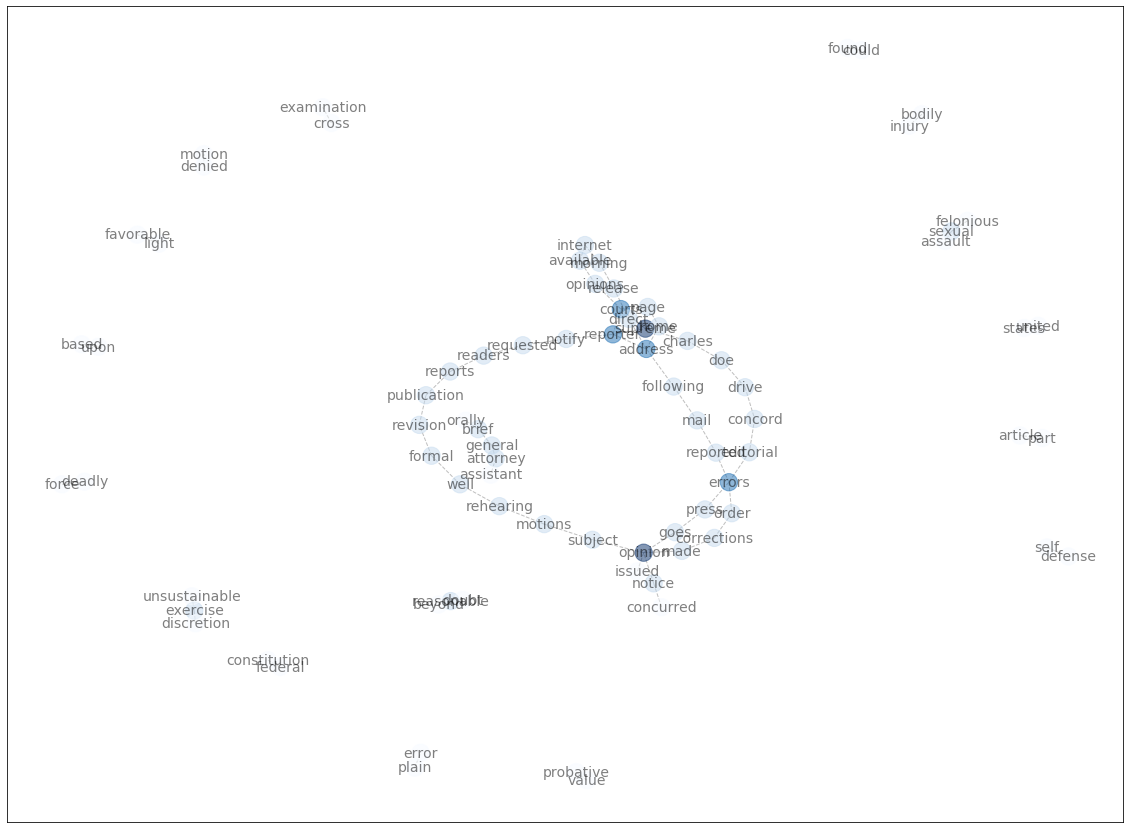

In [66]:
# Define de ngram
wordChain = 2

# Define list of important words
importantWords = ['informant']

for word in importantWords:
    print(f'Network graphic related to the word "{word}"')
    ngramsList_df = create_ngramlist(aff_non_info_all_words,wordChain, 70)
    create_graph_conections(word, ngramsList_df, "../../result/ngram/nh/informant_affirm.png", 10 ) 